## Importação dos pacotes

In [13]:
# importar pacotes necessários
import numpy as np
import pandas as pd

In [14]:
# definir parâmetros extras
#pd.set_option('precision', 2)
pd.set_option('display.max_columns', 100)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# importar pacotes usados na seleção do modelo e na medição da precisão
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# importar os pacotes necessários para os algoritmos de regressão
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import VotingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

## Carga dos dados de entrada

In [17]:
# carregar arquivo de dados de treino
data = pd.read_csv('abalone-train.csv', index_col='id')

# mostrar tamanho
print(data.shape)

# mostrar alguns exemplos de registros
data.head()

(2784, 9)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
id,,,,,,,,,
2758,M,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10
1384,F,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9
1131,M,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8
3726,I,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8
3445,I,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8


In [18]:
data_sex = pd.get_dummies(data['sex'], prefix='sex')

cols = {}
for col in data_sex.columns:
    cols[col] = col.lower()
data.rename(columns=cols, inplace=True)

data_sex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2784 entries, 2758 to 852
Data columns (total 3 columns):
sex_F    2784 non-null uint8
sex_I    2784 non-null uint8
sex_M    2784 non-null uint8
dtypes: uint8(3)
memory usage: 29.9 KB


In [19]:
data = data.join(data_sex)
data.drop('sex', axis=1, inplace=True)
data.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
2758,0.535,0.430,0.155,0.7845,0.3285,0.1690,0.2450,10,0,0,1
1384,0.630,0.485,0.170,1.3205,0.5945,0.3450,0.3450,9,1,0,0
1131,0.565,0.435,0.150,0.9900,0.5795,0.1825,0.2060,8,0,0,1
3726,0.500,0.395,0.145,0.7865,0.3320,0.1815,0.2455,8,0,1,0
3445,0.495,0.400,0.145,0.5780,0.2545,0.1305,0.1645,8,0,1,0


In [51]:
# excluir dados com valores inválidos
outliers = np.concatenate((
    data[data.height == 0.0].index,
    data[(data['viscera_weight'] > 0.5) & (data['rings'] < 20 - 1.5)].index,
    data[(data['viscera_weight'] < 0.5) & (data['rings'] > 25 - 1.5)].index,
    data[(data['shell_weight'] > 0.6) & (data['rings'] < 25- 1.5)].index,
    data[(data['shell_weight'] < 0.8) & (data['rings'] > 25- 1.5)].index,
    data[(data['shucked_weight'] >= 1.0) & (data['rings'] < 20- 1.5)].index,
    data[(data['shucked_weight'] < 1.0)  & (data['rings'] > 20- 1.5)].index,
    data[(data['whole_weight'] >= 2.5) & (data['rings'] < 25- 1.5)].index,
    data[(data['whole_weight'] < 2.5)  & (data['rings'] > 25- 1.5)].index,
    data[(data['diameter'] < 0.1)  & (data['rings'] < 5- 1.5)].index,
    data[(data['diameter'] < 0.6)  & (data['rings'] > 25- 1.5)].index,
    data[(data['diameter'] >= 0.6) & (data['rings'] < 25- 1.5)].index,
    data[(data['height'] > 0.4) & (data['rings'] < 15- 1.5)].index,
    data[(data['height'] < 0.4) & (data['rings'] > 25- 1.5)].index,
    data[(data['length'] < 0.1)  & (data['rings'] < 5- 1.5)].index,
    data[(data['length'] < 0.8)  & (data['rings'] > 25- 1.5)].index,
    data[(data['length'] >= 0.8) & (data['rings'] < 25- 1.5)].index
), axis=0)

print(type(outliers))
print(outliers)

<class 'numpy.ndarray'>
[3996 2624 1206 1763 3715 2710 3427 1422 2709 2863  170 1204 4148 1759
 2623 1052 3628 3149 2201  294  480 2108 4145  168 2274  169 1823 2265
  358  166 2368 3715 2334  375 1985 2210 2161 2088 2090 2623  277 2157
 1193 1052 1428 3149 2201  294  480 2544 1418 2624 1199 1206 1763 1756
 3007 1417 3715 3713 2710 3427 1754 1202 2863 1821 1426 3961 2675 1193
 1052  673  181  497  417  442  672  572  483 3149  469 2201  314 2277
 3914  256 3140  530 2199    6  166 2459 2275 2202  293 2335  593 3193
 3930  744 2334  674  351  375  294 2180 2344  431  372    9  480  232
   83  675  664  478  433   33 2101  278 2176  582  428 2108 2305  355
 3392  501  628  811 3244 3319 2351 1763 3715 2334 3149 2201  294  480
 2108  236  238 3149 2201  294  480 2108 1763 3715 2334 3427 1985 4148
 1052 1428 3992 1417 3149 2201  294  480 2108  236 3149 2201  294  480
 2108 2334 1428]


In [52]:
data[data.index.isin(outliers)].head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
id,,,,,,,,,,,
4145,0.670,0.525,0.200,1.7405,0.6205,0.2970,0.6570,11,0,0,1
168,0.705,0.560,0.220,1.9810,0.8175,0.3085,0.7600,14,0,0,1
2544,0.730,0.570,0.165,2.0165,1.0685,0.4180,0.4350,10,1,0,0
1418,0.705,0.555,0.215,2.1410,1.0465,0.3830,0.5280,11,0,0,1
2624,0.765,0.585,0.180,2.3980,1.1280,0.5120,0.5335,12,0,0,1


In [55]:
print("%d outliers to be dropped" % len(outliers))

print("before:", data.shape)
data.drop(outliers, inplace=True)
print("after:", data.shape)

171 outliers to be dropped
before: (2784, 11)
after: (2672, 11)


In [56]:
# definir dados de entrada

X = data.drop(['rings'], axis=1) # tudo, exceto a coluna alvo
y = data['rings'] # apenas a coluna alvo

print('Forma dos dados originais:', X.shape, y.shape)

Forma dos dados originais: (2672, 10) (2672,)


## Treinamento dos modelos preditivos

In [57]:
from sklearn.metrics import make_scorer, mean_squared_error

def root_mean_squared_error(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5

RMSE = make_scorer(root_mean_squared_error, greater_is_better=False)

In [58]:
def evaluate_model_cv(model, X=X, y=y):
  kfold = KFold(n_splits=10, random_state=42)
  results = cross_val_score(model, X, y, cv=kfold, scoring=RMSE, verbose=1)
  score = (-1) * results.mean()
  stddev = results.std()
  print(model, '\nCross-Validation Score: %.2f (+/- %.2f)' % (score, stddev))
  return score

In [59]:
# faz o ajuste fino do modelo, calculando os melhores hiperparâmetros
def fine_tune_model(model, params, X=X, y=y):
  print('\nFine Tuning Model:')
  print(model, "\nparams:", params)

  kfold = KFold(n_splits=10, random_state=42)
  grid = GridSearchCV(estimator=model, param_grid=params, scoring=RMSE, cv=kfold, verbose=1)
  grid.fit(X, y)

  print('\nGrid Best Score: %.2f' % (grid.best_score_ * (-1)))
  print('Best Params:', grid.best_params_)
 
  return grid

## Avaliação e ajuste fino de cada modelo preditivo

In [61]:
model = LinearRegression(n_jobs=2, fit_intercept=False, normalize=True)
evaluate_model_cv(model)

params = {'fit_intercept':[True, False], 'normalize':[True, False]}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=2, normalize=True) 
Cross-Validation Score: 1.92 (+/- 0.16)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [ ]:
model = LogisticRegression(n_jobs=2, random_state=42, multi_class='auto', C=1000, solver='newton-cg')
evaluate_model_cv(model)

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C':np.logspace(-3,3,7)
}
#fine_tune_model(model, params)

In [25]:
model = OrthogonalMatchingPursuit(n_nonzero_coefs=8, fit_intercept=True, normalize=True)
evaluate_model_cv(model)

params = {
    'n_nonzero_coefs': [None, 1, 2, 4, 6, 8, 10],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=8,
             normalize=True, precompute='auto', tol=None) 
Cross-Validation Score: 2.23 (+/- 0.17)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [26]:
model = PassiveAggressiveRegressor(random_state=42, C=0.2, fit_intercept=True)
evaluate_model_cv(model)

params = {
    'C': [0.1, 0.2, 0.4, 0.8, 1.0],
    'fit_intercept': [True, False],
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and

PassiveAggressiveRegressor(C=0.2, average=False, early_stopping=False,
              epsilon=0.1, fit_intercept=True, loss='epsilon_insensitive',
              max_iter=None, n_iter=None, n_iter_no_change=5,
              random_state=42, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False) 
Cross-Validation Score: 2.42 (+/- 0.22)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [31]:
model = Perceptron(random_state=42, penalty='l1', alpha=0.01, fit_intercept=True)
evaluate_model_cv(model)

#penalty=None, alpha=0.0001, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, 
#random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 6),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added 

Perceptron(alpha=0.01, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty='l1', random_state=42, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) 
Cross-Validation Score: 3.61 (+/- 0.35)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [29]:
model = RANSACRegressor(random_state=42, min_samples=0.75)
evaluate_model_cv(model)

#base_estimator=None, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None, max_trials=100, 
#max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss=’absolute_loss’, random_state=None

params = {
    'min_samples': [None, 0.1, 0.25, 0.5, 0.75, 1.0]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=0.75, random_state=42, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf) 
Cross-Validation Score: 2.24 (+/- 0.18)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.0s finished


In [27]:
model = Ridge(random_state=42, alpha=0.1, fit_intercept=False, normalize=True)
evaluate_model_cv(model)

#alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’, random_state=None

params = {
    'alpha': np.logspace(-6, -1, 4),
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=42, solver='auto', tol=0.001) 
Cross-Validation Score: 2.23 (+/- 0.17)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [32]:
model = SGDRegressor(random_state=42, alpha=1e-06, fit_intercept=False, penalty=None)
evaluate_model_cv(model)

#loss=’squared_loss’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, 
#verbose=0, epsilon=0.1, random_state=None, learning_rate=’invscaling’, eta0=0.01, power_t=0.25, early_stopping=False, 
#validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False

params = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-6, -1, 4),
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been ad

SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=False, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False) 
Cross-Validation Score: 2.69 (+/- 0.21)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


In [28]:
model = TheilSenRegressor(random_state=42, n_jobs=2, fit_intercept=True)
evaluate_model_cv(model)

#fit_intercept=True, copy_X=True, max_subpopulation=10000.0, n_subsamples=None, 
#max_iter=300, tol=0.001, random_state=None, n_jobs=None, verbose=False

params = {
    'fit_intercept': [True, False]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [29]:
model = KNeighborsRegressor(n_jobs=2, n_neighbors=11, weights='distance')
evaluate_model_cv(model)

#n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None

params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=2, n_neighbors=11, p=2,
          weights='distance') 
Cross-Validation Score: 2.24 (+/- 0.21)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished


In [30]:
model = SVR(gamma='auto', kernel='linear')
evaluate_model_cv(model)

#kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, tol=0.001, C=1.0, 
#epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 
Cross-Validation Score: 2.35 (+/- 0.23)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.0s finished


In [31]:
model = RandomForestRegressor(random_state=42, n_jobs=2, n_estimators=100, max_depth=7)
evaluate_model_cv(model)

#n_estimators=’warn’, criterion=’mse’, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
#min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False

params = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'max_depth': [None, 3, 5, 7, 9, 11, 13]
}
#fine_tune_model(model, params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False) 
Cross-Validation Score: 2.20 (+/- 0.20)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.4s finished


In [ ]:
# https://scikit-learn.org/stable/modules/classes.html

In [43]:
model = GradientBoostingRegressor(random_state=42)
evaluate_model_cv(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False) 
Cross-Validation Score: 2.22 (+/- 0.20)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished


2.2246574460647914

In [44]:
model = DecisionTreeRegressor(random_state=42)
evaluate_model_cv(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best') 
Cross-Validation Score: 3.11 (+/- 0.19)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


3.1109542059076007

In [45]:
model = GaussianProcessRegressor()
evaluate_model_cv(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None) 
Cross-Validation Score: 44.61 (+/- 51.76)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


44.609203304259225

In [46]:
model = MLPRegressor(random_state=42)
evaluate_model_cv(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
Cross-Validation Score: 2.20 (+/- 0.19)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.5min finished


2.201780707817829

## Comparação final entre os algoritmos

In [28]:
models = []
models.append(('LR', LogisticRegression(random_state=42, solver='lbfgs', multi_class='auto', max_iter=500, C=100)))
models.append(('DT', DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=11)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=1)))
models.append(('SVM', SVC(random_state=42, C=10, gamma=0.1, kernel='rbf')))
models.append(('RF', RandomForestClassifier(random_state=42, max_features='auto', n_estimators=10)))
models.append(('SGD', SGDClassifier(random_state=42, max_iter=100, tol=0.1)))
models.append(('NN', Perceptron(random_state=42, max_iter=100, tol=0.01)))
models.append(('NB', GaussianNB(priors=None, var_smoothing=1e-08)))
models.append(('LSVM', LinearSVC(random_state=42, max_iter=1000, C=10)))
models.append(('ABDT', AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=5)))
models.append(('GB', GradientBoostingClassifier(random_state=42, max_depth=3)))
models.append(('MLP', MLPClassifier(random_state=42, solver='lbfgs', alpha=0.1, hidden_layer_sizes=(15,))))
models.append(('LDA', LinearDiscriminantAnalysis(solver='svd')))

In [29]:
results = []
names = []
scores = []
stddevs = []

for name, model in models:
  kfold = KFold(n_splits=10, random_state=42)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  scores.append(cv_results.mean() * 100)
  stddevs.append(cv_results.std() * 100)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.964762 (0.047581)
DT: 0.972857 (0.044673)
KNN: 0.971905 (0.046969)
SVM: 0.985714 (0.028571)
RF: 0.965238 (0.047239)
SGD: 0.923333 (0.066648)
NN: 0.936667 (0.067312)
NB: 0.971905 (0.046969)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

LSVM: 0.957619 (0.056922)
ABDT: 0.965714 (0.045466)
GB: 0.972381 (0.045115)
MLP: 0.978571 (0.045737)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.923333 (0.059608)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


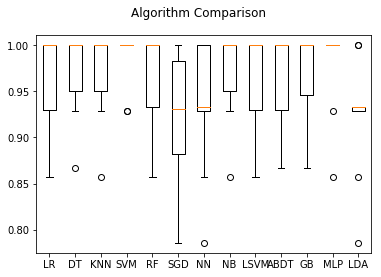

In [30]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [31]:
results = pd.DataFrame({'Model': names, 'Score': scores, 'Std Dev': stddevs})
results.sort_values(by='Score', ascending=False)

,Model,Score,Std Dev
3,SVM,98.571429,2.857143
11,MLP,97.857143,4.573660
1,DT,97.285714,4.467316
10,GB,97.238095,4.511512
2,KNN,97.190476,4.696938
7,NB,97.190476,4.696938
9,ABDT,96.571429,4.546559
4,RF,96.523810,4.723896
0,LR,96.476190,4.758094
8,LSVM,95.761905,5.692219
